In [1]:
import numpy as np
import pickle
from pathlib import Path
import torch
from sklearn.model_selection import train_test_split
# import wandb

from albumentations.augmentations.transforms import Flip
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
import cv2
# import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

In [ ]:
val_loader = create_test_loader(X_val, y_val, batch_size=8)

# Predict

In [30]:
def scaler(image):
    return (image - image.min()) / (image.max() - image.min())


def predict_slice(image_slice, model, device, transforms, pad_size, predict_size, write_mask_size, repeat_input=3):
    model.eval()

    mask_slice = np.zeros(image_slice.shape)
    pad_mask_x = mask_slice.shape[0] % write_mask_size
    pad_mask_y = mask_slice.shape[1] % write_mask_size
    mask_slice = np.pad(mask_slice, [(0, pad_mask_x), (0, pad_mask_y)], mode='constant')
    image_slice = np.pad(image_slice, [(pad_size, pad_size), (pad_size, pad_size)], mode='edge')

    add_pad = (image_slice.shape[0] - pad_size * 2) % write_mask_size
    if add_pad != 0:
        image_slice = np.pad(image_slice, [(0, add_pad), (0, 0)], mode='edge')
    add_pad = (image_slice.shape[1] - pad_size * 2) % write_mask_size
    if add_pad != 0:
        image_slice = np.pad(image_slice, [(0, 0), (0, add_pad)], mode='edge')
    x_steps = (image_slice.shape[0] - pad_size * 2) // write_mask_size
    y_steps = (image_slice.shape[1] - pad_size * 2) // write_mask_size


    for i in range(x_steps):
        for j in range(y_steps):
            input_image = image_slice[i * write_mask_size: i * write_mask_size + predict_size,
                                      j * write_mask_size: j * write_mask_size + predict_size]
            input_image = scaler(input_image)
            input_image = np.repeat(input_image[..., None], repeat_input, axis=2)
            input_image = transforms(image=input_image)['image']
            with torch.no_grad():
                output_mask = model(input_image[None, ...].to(device)).sigmoid().squeeze().cpu().numpy()
            output_mask = output_mask[pad_size:-pad_size, pad_size:-pad_size]
            mask_slice[i * write_mask_size:(i + 1) * write_mask_size,
                       j * write_mask_size:(j + 1) * write_mask_size] = output_mask
    return mask_slice[: mask_slice.shape[0] - pad_mask_x, : mask_slice.shape[1] - pad_mask_y]

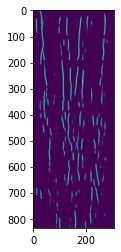

In [31]:
img_idx = 0

image = x_test[img_idx]

img_transforms = A.Compose([
    A.Normalize(max_pixel_value=1.0),
    ToTensorV2()
])

device = torch.device("cpu")

plt.imshow(predict_slice1(image, model, device, img_transforms, pad_size=16, predict_size=128, write_mask_size=96, repeat_input=3))

# Model

In [3]:
class FaultSegmentator:
    def __init__(self, path=None):
        self.model = smp.Unet(
            encoder_name="efficientnet-b3",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1
        )
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if path:
            self.load(path)

    def load(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        
    def predict_slice(self, image_slice, pad_size=16, predict_size=128, write_mask_size=96, repeat_input=3):
        self.model.eval()

        mask_slice = np.zeros(image_slice.shape)
        pad_mask_x = mask_slice.shape[0] % write_mask_size
        pad_mask_y = mask_slice.shape[1] % write_mask_size
        mask_slice = np.pad(mask_slice, [(0, pad_mask_x), (0, pad_mask_y)], mode='constant')
        image_slice = np.pad(image_slice, [(pad_size, pad_size), (pad_size, pad_size)], mode='edge')

        add_pad = (image_slice.shape[0] - pad_size * 2) % write_mask_size
        if add_pad != 0:
            image_slice = np.pad(image_slice, [(0, add_pad), (0, 0)], mode='edge')
        add_pad = (image_slice.shape[1] - pad_size * 2) % write_mask_size
        if add_pad != 0:
            image_slice = np.pad(image_slice, [(0, 0), (0, add_pad)], mode='edge')
        x_steps = (image_slice.shape[0] - pad_size * 2) // write_mask_size
        y_steps = (image_slice.shape[1] - pad_size * 2) // write_mask_size


        for i in range(x_steps):
            for j in range(y_steps):
                input_image = image_slice[i * write_mask_size: i * write_mask_size + predict_size,
                                          j * write_mask_size: j * write_mask_size + predict_size]
                input_image = self.scale(input_image)
                input_image = np.repeat(input_image[..., None], repeat_input, axis=2)
                input_image = self.get_image_transformer()(image=input_image)['image']
                with torch.no_grad():
                    output_mask = self.model(input_image[None, ...].to(self.device)).sigmoid().squeeze().cpu().numpy()
                output_mask = output_mask[pad_size:-pad_size, pad_size:-pad_size]
                mask_slice[i * write_mask_size:(i + 1) * write_mask_size,
                           j * write_mask_size:(j + 1) * write_mask_size] = output_mask
        return mask_slice[: mask_slice.shape[0] - pad_mask_x, : mask_slice.shape[1] - pad_mask_y]
    
    @staticmethod
    def get_image_transformer():
        return A.Compose([
            A.Normalize(max_pixel_value=1.0),
            ToTensorV2()
        ])
    
    @staticmethod
    def scale(image):
        return (image - image.min()) / (image.max() - image.min())
fsegmentator = FaultSegmentator(path="../web_application/segmentator/model.pt")

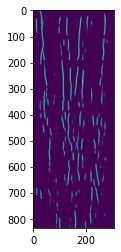

In [5]:
plt.imshow(fsegmentator.predict_slice(x_test[0]))

In [4]:
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

with open('lyc_data.pickle', 'rb') as handle:
    data_set = pickle.load(handle)  
    x_test = data_set['x_set']
    y_test= data_set['y_set']
    for i in range(len(y_test)):
        y_test[i][y_test[i] > 0] = 1

len(x_test)

93

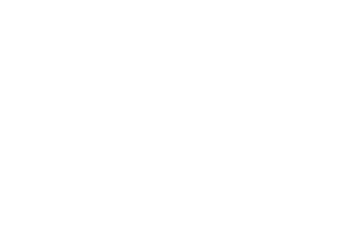

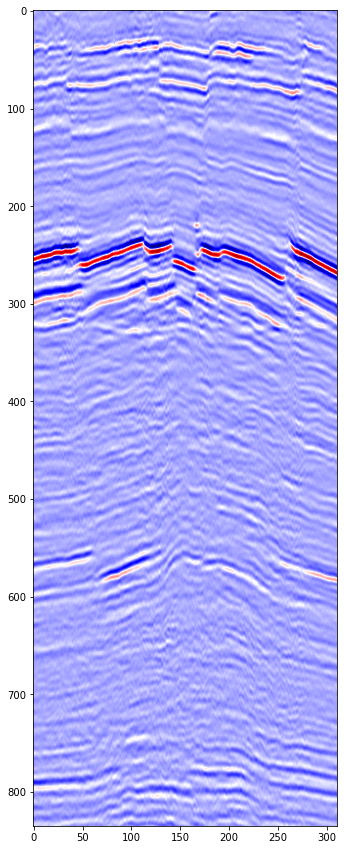

In [129]:
image_slice =  x_test[0]
plt.axis('off')
plt.figure(figsize=(15, 15))

plt.imshow(image_slice, cmap='seismic')
plt.savefig("test2.png", pad_inches=0, bbox_inches="tight", transparent=True)

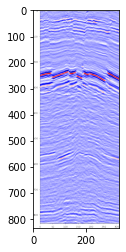

In [79]:
from PIL import Image
plt.imshow(np.asarray(Image.open("test1.png")))

In [80]:
Image.open("test1.png").size

(329, 835)

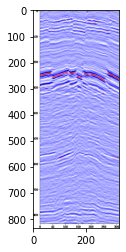

In [93]:
plt.imshow(np.asarray(Image.open("test1.png"))[..., :3])

In [88]:
np.asarray(Image.open("test1.png"))[:3]

array([[[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]]], dtype=uint8)

In [94]:
x_test[0]

array([[  682.438 ,   682.438 ,   682.438 , ..., -1706.095 ,  -682.438 ,
         -341.219 ],
       [ 1023.657 ,  1023.657 ,  1023.657 , ..., -2047.3142, -1364.876 ,
        -1023.657 ],
       [ 1023.657 ,  1023.657 ,   682.438 , ..., -1706.095 , -1706.095 ,
        -1364.876 ],
       ...,
       [ 2388.5332,  2388.5332,  2388.5332, ...,  1023.657 ,  1023.657 ,
          682.438 ],
       [ 2388.5332,  2729.7522,  2388.5332, ...,  1364.876 ,  1364.876 ,
         1364.876 ],
       [ 2047.3142,  2047.3142,  2047.3142, ...,  1023.657 ,  1023.657 ,
         1364.876 ]], dtype=float32)

In [71]:
def load_image(infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

load_image("test1.png")

array([[[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       ...,

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255

In [104]:
Image.fromarray(x_test[0], "tif")


ValueError: unrecognized image mode

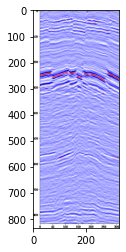

In [125]:
plt.imshow(plt.imread("test2.png")[..., :3])

In [134]:
x_test[0].shape, plt.imread("test2.png").shape

((835, 311), (835, 311, 4))

In [130]:
plt.imsave("test2.png", x_test[0])

In [132]:
x_test[0]

array([[  682.438 ,   682.438 ,   682.438 , ..., -1706.095 ,  -682.438 ,
         -341.219 ],
       [ 1023.657 ,  1023.657 ,  1023.657 , ..., -2047.3142, -1364.876 ,
        -1023.657 ],
       [ 1023.657 ,  1023.657 ,   682.438 , ..., -1706.095 , -1706.095 ,
        -1364.876 ],
       ...,
       [ 2388.5332,  2388.5332,  2388.5332, ...,  1023.657 ,  1023.657 ,
          682.438 ],
       [ 2388.5332,  2729.7522,  2388.5332, ...,  1364.876 ,  1364.876 ,
         1364.876 ],
       [ 2047.3142,  2047.3142,  2047.3142, ...,  1023.657 ,  1023.657 ,
         1364.876 ]], dtype=float32)

In [133]:
plt.imsave("test2.png", x_test[0])
plt.imread("test2.png").shape

(835, 311, 4)

In [7]:
import imageio
import matplotlib.image as mpimg
imageio.imwrite("test2.png", x_test[0])
uploaded_image = mpimg.imread("test2.png")

Lossy conversion from float32 to uint8. Range [-19790.703125, 27979.9609375]. Convert image to uint8 prior to saving to suppress this warning.


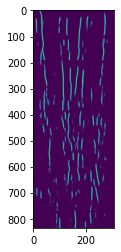

In [10]:
plt.imshow(fsegmentator.predict_slice(uploaded_image))

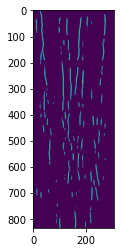

In [22]:
plt.imshow(prediction * (prediction > 0.5))

In [25]:
norm_pred = prediction * (prediction > 0.5)
norm_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
np.where(norm_pred)

(array([  2,   3,   3, ..., 834, 834, 834]),
 array([ 27,  27,  28, ..., 160, 161, 162]))

In [11]:
prediction = fsegmentator.predict_slice(uploaded_image)

In [15]:
uploaded_image

array([[0.42745098, 0.42745098, 0.42745098, ..., 0.38039216, 0.4       ,
        0.40784314],
       [0.43529412, 0.43529412, 0.43529412, ..., 0.37254903, 0.38431373,
        0.39215687],
       [0.43529412, 0.43529412, 0.42745098, ..., 0.38039216, 0.38039216,
        0.38431373],
       ...,
       [0.4627451 , 0.4627451 , 0.4627451 , ..., 0.43529412, 0.43529412,
        0.42745098],
       [0.4627451 , 0.47058824, 0.4627451 , ..., 0.44313726, 0.44313726,
        0.44313726],
       [0.45882353, 0.45882353, 0.45882353, ..., 0.43529412, 0.43529412,
        0.44313726]], dtype=float32)

In [27]:
res = uploaded_image.copy()
res[np.where(norm_pred)] = 1

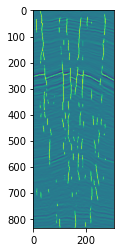

In [28]:
plt.imshow(res)

In [43]:
apply_mask(uploaded_image, prediction).max()

1.0

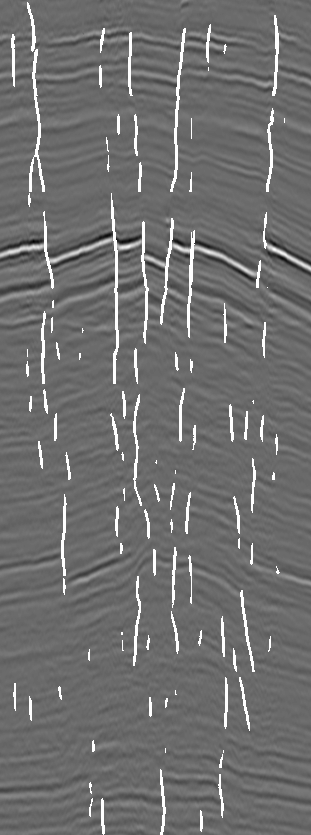

In [47]:
def apply_mask(img, mask):
    mask *= (mask > 0.5)
    new_img = img.copy()
    new_img[np.where(mask)] = 1
    return new_img * 255
Image.fromarray(apply_mask(uploaded_image, prediction)).convert("L")

In [32]:
from PIL import Image